In [10]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import scipy.linalg as la
import scipy.integrate as integrate

from graphic_tools import simple_plotter, show_state, visualize_u_from_F
from burgers import get_burgers, get_burgers_fd, get_burgers_cons_fd, get_burgers_nicolson
from generators import burgers_snapshot_generator, get_burgers_batch
from initial_functions import random_init, high_dim_random_init, burgers_analytical_init
from analysis_tools import relative_err, rmse, check_weights, downsampling
from training_dataset import generate_burgers_training_dataset, read_dataset

---

# Burgers equation - reconstruction experiments

--- 
##  Training

Let's make a set of initial conditions which will be used for references, training, validation and test

### Initial conditions

In [97]:
t_n = 4096
x_n = 4096
x_min = 0.
x_max = 1.
t_min = 0.
t_max = 0.5
nu = 0.003

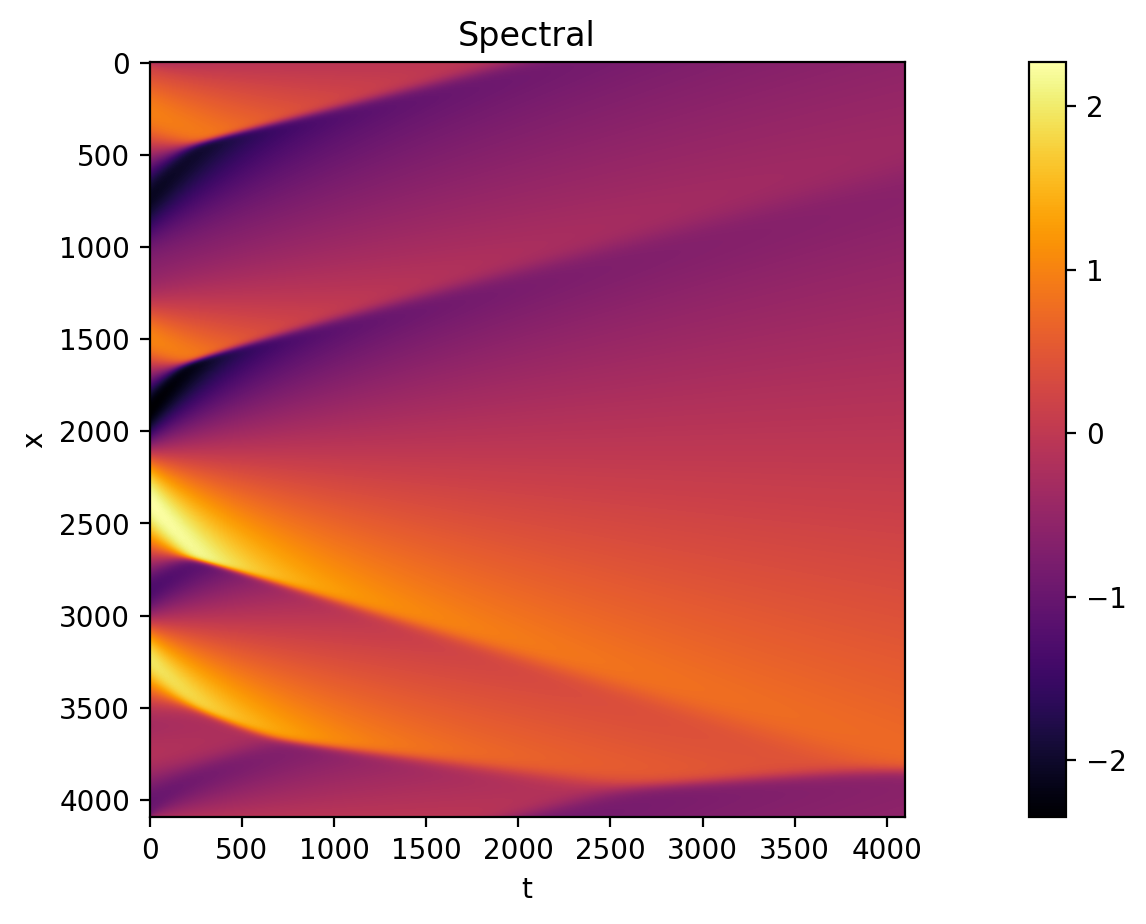

In [99]:
t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

k = 2 * np.pi * np.fft.fftfreq(x_n, d=dx)

def burgers_pde(u, t, k=k, nu=nu):
    # Fourier domain
    u_hat = np.fft.fft(u)
    u_hat_x = 1j * k * u_hat
    u_hat_xx = -k**2 * u_hat
    
    # Spatial domain
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    
    u_t = -u * u_x + nu * u_xx
    return u_t.real

u0 = high_dim_random_init(t, x)
bu0 = u0[0, 1:-1]
test = integrate.odeint(burgers_pde, bu0, t, args=(k, nu,))
show_state(test.T, 'Spectral', 't', 'x', None)

In [ ]:
def get_D(X, s):
    d = np.zeros((X, X))
    for i in range(X):
        d[i][i] = 1 - s

    for i in range(X-1):
        d[i][i+1] = s / 2
        d[i+1][i] = s / 2

    return d


def get_M(X, u, dt, dx, nu):
    M = np.zeros((X, X))
    s = nu * dt / dx**2
    b = 1 + s

    for i in range(X):
        M[i][i] = b

    for i in range(X-1):
        M[i+1][i] = -dt / (4 * dx) * u[i-1] - s / 2
        M[i][i+1] = dt / (4 * dx) * u[i+1] - s / 2

    return M


def get_burgers_nicolson(dt, dx, t_n, x_n, nu, u0):
    """
    Crank-Nicolson algorithm for 1D non-conservative viscous burgers equation.
    """
    s = nu * dt / dx**2
    d = get_D(x_n, s)

    u = np.zeros((t_n, x_n))
    u[0, :] = np.copy(u0[0, 1:-1])

    for i in range(1, t_n):
        b = d @ u[i-1, :]
        m = get_M(x_n, u[i-1, :], dx, dt, nu)
        u[i, :] = la.solve(m, b)

    return u

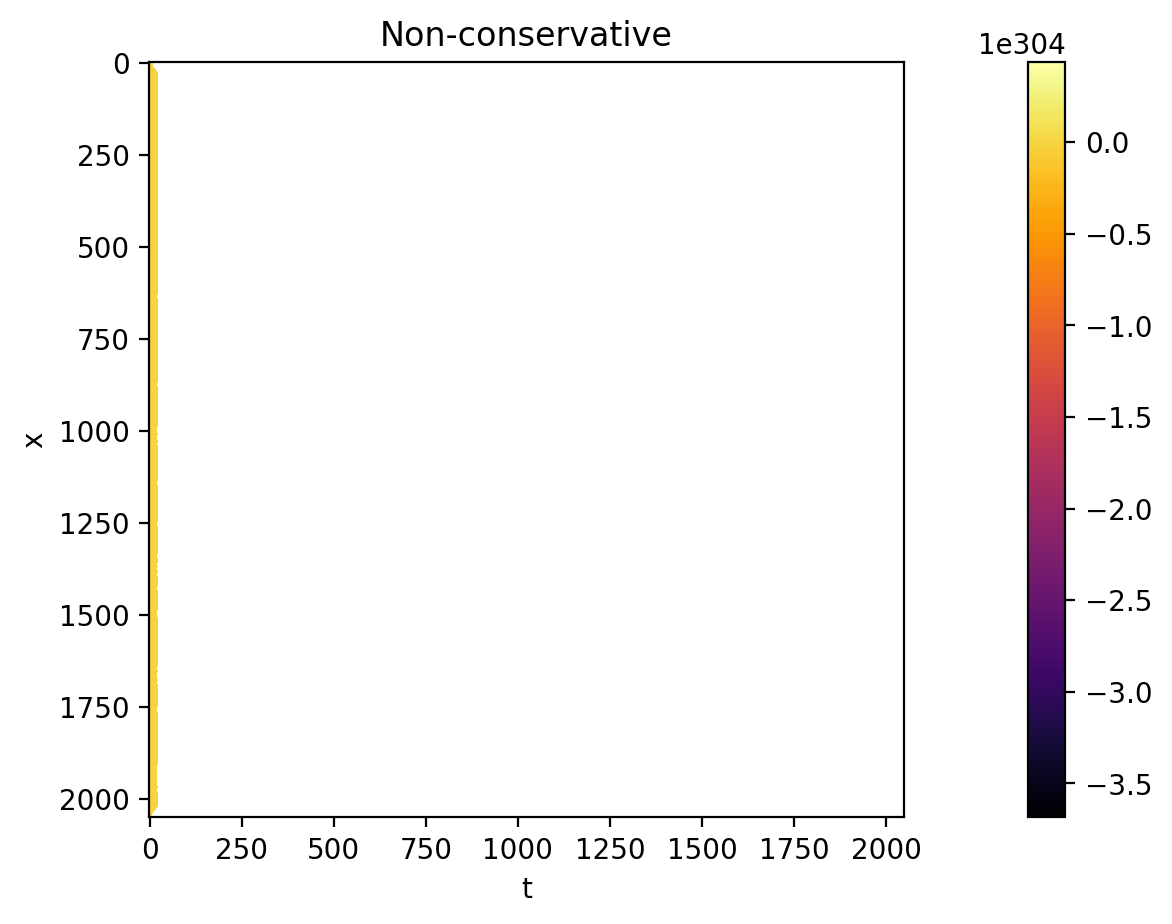

In [94]:
# (Von Neumann analysis to do ?) Non-linear not possible

# u0 = random_init(t, x)

u_df = get_burgers_fd(dt, dx, t_n, nu, u0)
#u_cons = get_burgers_cons_fd(dt, dx, t_n, nu, u0)
u_nic = get_burgers_nicolson(dt, dx, t_n, x_n, nu, u0)

show_state(u_df.T, 'Non-conservative', 't', 'x', None)
#show_state(u_cons.T, 'Conservative', 't', 'x', None)
#show_state(u_nic.T, 'Nicolson', 't', 'x', None)

---

### Full-order model - Coarse grid

Several training datasets of high-dimension are generated, downsampled and compare to coarse grid solution as a point of comparison.

In [ ]:
# training_set = generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 10, 0, './dataset/random_burgers_training_set.pt')
training_set = read_dataset('dataset/random_burgers_training_set.pt')

In [ ]:
def coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, dataset):
    batch_size = len(dataset)
    
    t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
    x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

    rmse_tot = 0
    re_tot = 0
    for i in range(batch_size):
        # Get downsize solution
        t, u, _, _ = dataset[i]
        u = u.detach().numpy()
        
        # Generate coarse grid solution
        u0 = np.zeros((t_n, x_n + 2))
        u0[0, 1:-1] = u[0, :]
        pred_u, _ = get_burgers_fd(dt, dx, t_n, x_n, u0)
        
        # Compute rmse and relative error
        re_tot += relative_err(u.T, pred_u[:, 1:-1].T)
        rmse_tot += rmse(pred_u[:, 1:-1].T, u.T)

    print(rmse_tot / batch_size)
    print(np.mean(re_tot) / batch_size)
    

coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, training_set)

In [ ]:
def old_burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu):
    rand_init = np.random.randint(2)
    init = {
        0: random_init(t, x),
        1: high_dim_random_init(t, x)
    }
    
    u0 = init[rand_init]
    u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
    
    if np.isfinite(u_df).sum() != (u_df.shape[0] * u_df.shape[1]):
        u0 = burgers_analytical_init(t, x, nu)
        u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
    
    return torch.from_numpy(u_df).float()

In [ ]:
def old_get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu):
    t_batch_size = t_n # batch size de taille != t_n ?
    
    # We generate our time and space axis
    t_range = np.linspace(t_min, t_max, t_batch_size)

    # Then compute a snapshot of the solution u(t, x).
    u_s = burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu)
    
    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range).float()
    batch_u0 = u_s[0, :]
    batch_u = torch.stack([u_s[i, :]**2 for i in range(0, t_batch_size)], dim=0)
    
    return batch_t, batch_u0, batch_u

In [ ]:
_, _, test = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, 0)
show_state(test.T, 'u', 't', 'x', None)

---

## Operator F reconstruction

### Model used by ODE solver

Let's define a few neural ODE model to use. First, with a basic linear one-layer model, efficient to work on linear PDE like Heat equation, but not for a non-linear PDE such as the Burgers equation.

In [ ]:
class ODEModel(nn.Module):
    def __init__(self, n=500):
        super(ODEModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 2*n),
            nn.Tanh(),
            nn.Linear(2*n, 2*n),
            nn.Tanh(),
            nn.Linear(2*n, n),
            nn.Tanh()
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

In [ ]:
class BurgersModelA(nn.Module):
    def __init__(self):
        super(BurgersModelA, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh()
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Implementation of the neural ODE

Let's now write our neural ODE. In a first time we will generate some data and
process them in a format usable by PyTorch and the ODESolver (torchdiffeq).

Let's write a small training loop for our neural ode.

In [ ]:
def loss_fn(pred_x, x):
    return nn.MSELoss()(pred_x, x)

In [ ]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, nu=0.003, batch_size=10):
    optimizer = optim.RMSprop(net.parameters(), lr=0.003)

    for e in range(1, epochs + 1):
        print("Epoch ", e)
        loss_tot = 0
        val_loss_tot = 0
        
        net.train()
        for i in range(batch_size):
            print("Batch ", i)
            optimizer.zero_grad()
            t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, 0)
            pred_u = odeint(net, b0[1:-1], t)
            loss = loss_fn(pred_u, bu[:, 1:-1])
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()

        if e % 1 == 0:
            t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, 0)
            visualize_u_from_F(net, t, bu[:,1:-1], b0[1:-1])
            
            print('Epoch %d loss %f'%(e, float(loss_tot / float(batch_size))))
    
    return net

In [ ]:
%matplotlib inline
net = ODEModel(x_n)
F2 = training_ode_solver_net(net, 5, t_n, x_n, nu)

In [ ]:
t, b0, bu = get_batch(0.2, 0.0, 1.0, 0.0, t_n, x_n, nu)
visualize_u_from_F(F2, t, bu[:,1:-1], b0[1:-1])